### Build a Basic Chatbot with Langgraph ( Graph API )


In [ ]:
import os 
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


load_dotenv()


True

In [6]:
class State(TypedDict):
    ## """State type for the graph."""
    messages: Annotated[list, add_messages]  # type: ignore[valid-type]

graph_builder = StateGraph(State)

In [7]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama-3.3-70b-versatile")
llm = init_chat_model("groq:llama-3.3-70b-versatile")
             

In [8]:
## Node Functionality
def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

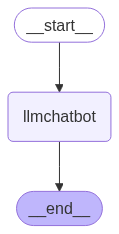

In [9]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

## Compile the graph
graph = graph_builder.compile()

## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [10]:
response = graph.invoke(
    {
        "messages": "Hello"
    }
)
response["messages"][-1].content

'Hello. How can I assist you today?'

In [11]:
## Stream the response
for event in graph.stream(
    {
        "messages": "Hello, How are you ?"
    }
):
    for vlaue in event.values():
        print(vlaue["messages"][-1].content)

Hello, I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going?


### CHATBOT WITH TOOLS


In [12]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)
tavily_tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'List of capitals of France - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
   'content': "List of capitals of France - Wikipedia Article [x] Tools  This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.[1] Paris (987–1419), the residence of the Kings of France, although they were consecrated at Reims. Troyes (1419–1422), for a short time during the Hundred Years' War, the city was the seat of the royal government. Paris (1594–1682)[citation needed] Tours (10–13 June 1940), the city served as the temporary capital of France during World War II after the government fled Paris due to the German advance. Algiers (1943–1944), the city was made the seat of Free France, to be closer to the war in Europe. *   All articles needing additional references",
   'score': 0.

In [13]:
## Custom Function
def multiply(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a * b

tools = [tavily_tool, multiply]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools


RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10f4c0990>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10f4c1910>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of do

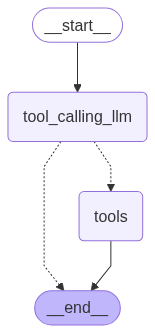

In [14]:
## StateGraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state: State):
    return {"messages": [
        llm_with_tools.invoke(
            state["messages"])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              ## If the latest message is a tool call --> tools_condition route to tools
                              ## If the latest message is not a tool call, route to END
                              tools_condition)
builder.add_edge("tools", END)

## Compile the graph
graph_with_tools = builder.compile()
## Visualize the graph
display(Image(graph_with_tools.get_graph().draw_mermaid_png()))


In [15]:
response = graph_with_tools.invoke(    {
        "messages": "What is capital of India?"
    }
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is capital of India?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a1vb6qdx8)
 Call ID: a1vb6qdx8
  Args:
    query: Capital of India
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Capital of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "New Delhi - Wikipedia", "url": "https://en.wikipedia.org/wiki/New_Delhi", "content": "New Delhi (/ ˈ nj uː ˈ d ɛ. l i / ⓘ; [6] Hindi: Naī Dillī, pronounced [ˈnəiː ˈdɪlːiː]) is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government of India, hosting the Rashtrapati Bhavan, Sansad Bhavan, and the Supreme Court.New Delhi is a municipality within the NCT, administered by

In [16]:
response1 = graph_with_tools.invoke(    {
        "messages": "What is 30 multiplied by 40 and then multiply it by 20 and then give me the recent AI news ?"
    }
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is capital of India?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a1vb6qdx8)
 Call ID: a1vb6qdx8
  Args:
    query: Capital of India
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Capital of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "New Delhi - Wikipedia", "url": "https://en.wikipedia.org/wiki/New_Delhi", "content": "New Delhi (/ ˈ nj uː ˈ d ɛ. l i / ⓘ; [6] Hindi: Naī Dillī, pronounced [ˈnəiː ˈdɪlːiː]) is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government of India, hosting the Rashtrapati Bhavan, Sansad Bhavan, and the Supreme Court.New Delhi is a municipality within the NCT, administered by

### ReAct Agent Architecture


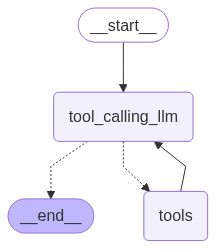

In [17]:
## StateGraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state: State):
    return {"messages": [
        llm_with_tools.invoke(
            state["messages"])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              ## If the latest message is a tool call --> tools_condition route to tools
                              ## If the latest message is not a tool call, route to END
                              tools_condition)
builder.add_edge("tools", "tool_calling_llm")

## Compile the graph
graph_with_react = builder.compile()
## Visualize the graph
display(Image(graph_with_react.get_graph().draw_mermaid_png()))

In [18]:
response2 = graph_with_react.invoke(    {
        "messages": "Give me the recent AI news"
    }
)
for m in response2["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a708ejpjz)
 Call ID: a708ejpjz
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.pcgamer.com/software/ai/an-ai-holds-the-top-slot-in-a-leaderboard-that-ranks-people-who-hunt-for-system-vulnerabilities-used-by-hackers/", "title": "An AI holds the top slot in a leaderboard that ranks people who hunt for system vulnerabilities used by hackers - PC Gamer", "score": 0.6780931, "published_date": "Wed, 25 Jun 2025 16:30:18 GMT", "content": "holds a smartphone displaying the logo of “Claude,” an AI language model b

### Memory in Agents


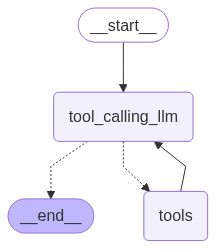

In [ ]:
## StateGraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state: State):
    return {"messages": [
        llm_with_tools.invoke(
            state["messages"])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              ## If the latest message is a tool call --> tools_condition route to tools
                              ## If the latest message is not a tool call, route to END
                              tools_condition)
builder.add_edge("tools", "tool_calling_llm")

## Compile the graph
graph_with_mem = builder.compile(checkpointer=memory)
## Visualize the graph
display(Image(graph_with_mem.get_graph().draw_mermaid_png()))

In [ ]:
## Add configurable thread_id to the config
config = {"configurable": {"thread_id":"1"}}

response_with_mem = graph_with_mem.invoke({"messages": "Hello, my name is Abhishek"},config=config)
for m in response_with_mem["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Abhishek
================================== Ai Message ==================================

It's nice to meet you, Abhishek. Is there something I can help you with or would you like to chat?


In [27]:
response_with_mem = graph_with_mem.invoke({"messages": "My parents are Nidhi Seth & Dilip Seth. Now tell me what are my parents name ?"},config=config)
for m in response_with_mem["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Abhishek
================================== Ai Message ==================================

It's nice to meet you, Abhishek. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hello, what is my name ?
================================== Ai Message ==================================

Your name is Abhishek.
================================ Human Message =================================

My parents are Nidhi Seth & Dilip Seth. Now tell me what are my parents name ?
================================== Ai Message ==================================

Your parents' names are Nidhi Seth and Dilip Seth.


In [29]:
response_with_mem = graph_with_mem.invoke({"messages": "Who is Nidhi seth ?"},config=config)
for m in response_with_mem["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Abhishek
================================== Ai Message ==================================

It's nice to meet you, Abhishek. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Hello, what is my name ?
================================== Ai Message ==================================

Your name is Abhishek.
================================ Human Message =================================

My parents are Nidhi Seth & Dilip Seth. Now tell me what are my parents name ?
================================== Ai Message ==================================

Your parents' names are Nidhi Seth and Dilip Seth.
================================ Human Message =================================

Who is dilip seth ?
================================== Ai Message ==================================

According to our con

### Streaming in Langgraph

In [30]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [31]:
def superBot(state:State):
    return {"messages": [
        llm_with_tools.invoke(
            state["messages"])]}

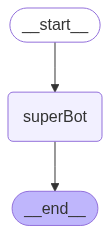

In [32]:
graph = StateGraph(State)
graph.add_node("superBot", superBot)
graph.add_edge(START, "superBot")
graph.add_edge("superBot", END)

graph_builder = graph.compile(checkpointer=memory)
## Visualize the graph
try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [33]:
## Invoke the graph

config = {"configurable": {"thread_id":"1"}}
response = graph_builder.invoke(
    {        "messages": "Hello, My name is Abhishek, and I like cricket"
    },config=config
)
response

{'messages': [HumanMessage(content='Hello, My name is Abhishek, and I like cricket', additional_kwargs={}, response_metadata={}, id='c6b57dd5-6a40-4020-a74d-a18aa0a77ac5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e813ebdrh', 'function': {'arguments': '{"query":"cricket news","search_depth":"basic","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1305, 'total_tokens': 1336, 'completion_time': 0.12811925, 'prompt_time': 0.07826469, 'queue_time': 0.05264737, 'total_time': 0.20638394}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0290929e-5c11-46ac-9713-ef02ab131629-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'cricket news', 'search_depth': 'basic', 'topic': 'news'}, 'id': 'e813ebdrh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1305, 'output_tokens': 

In [34]:
## Streaming in Langgraph
# 1. **Stream Mode**: Langgraph supports streaming responses, allowing for real-time interaction with the model, which is useful for applications requiring immediate feedback.
# 2. **Updates Stream Mode**: The `stream_mode` parameter can be set to "updates" to receive incremental updates during the response generation, enabling dynamic content delivery.     

## UPDATES Stream mode in Langgraph
config = {"configurable": {"thread_id":"3"}}

for chunk in graph_builder.stream(
    {        "messages": "Hello, My name is Abhishek, and I like cricket"
    },config=config,
    ## Set the stream mode to UPDATES
    stream_mode = "updates"

):
    print(chunk)

{'superBot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4zg24rpcd', 'function': {'arguments': '{"query":"cricket news","search_depth":"basic","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1305, 'total_tokens': 1336, 'completion_time': 0.127245975, 'prompt_time': 0.081634624, 'queue_time': 0.05307102600000001, 'total_time': 0.208880599}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--616f0739-f732-454d-8bbd-36b5b1ad4fa7-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'cricket news', 'search_depth': 'basic', 'topic': 'general'}, 'id': '4zg24rpcd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1305, 'output_tokens': 31, 'total_tokens': 1336})]}}


In [35]:
## VALUES Stream mode in Langgraph
for chunk in graph_builder.stream(
    {        "messages": "Hello, My name is Abhishek, and I like cricket"
    },config=config,
    ## Set the stream mode to UPDATES
    stream_mode = "values"

):
    print(chunk)

{'messages': [HumanMessage(content='Hello, My name is Abhishek, and I like cricket', additional_kwargs={}, response_metadata={}, id='fc38f559-fdb1-4f9c-8c91-bf56431bbf0a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4zg24rpcd', 'function': {'arguments': '{"query":"cricket news","search_depth":"basic","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1305, 'total_tokens': 1336, 'completion_time': 0.127245975, 'prompt_time': 0.081634624, 'queue_time': 0.05307102600000001, 'total_time': 0.208880599}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--616f0739-f732-454d-8bbd-36b5b1ad4fa7-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'cricket news', 'search_depth': 'basic', 'topic': 'general'}, 'id': '4zg24rpcd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1305, '